In [56]:
import os

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import numpy as np

import json
import csv

import random

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analyzing the MUSE alignments

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from numpy.linalg import svd

def load_embeddings(file_path, source, target, base_path="/content/drive/MyDrive/analogy/s2orc/20200705v1/full/level1.abstract.api/MUSE/"):
  src_vectors = KeyedVectors.load_word2vec_format(base_path+file_path+'vectors-'+source+'.txt', binary=False)
  tgt_vectors = KeyedVectors.load_word2vec_format(base_path+file_path+'vectors-'+target+'.txt', binary=False)
  return src_vectors, tgt_vectors

## Load subset of abstracts and preprocess

In [59]:
import pandas as pd, re
# Processing abstracts
comm_name_list = ["Immigrant", "ethnic-racial", "professional", "participant.v2__hci", "participant.v2__edu", "participant.v2__ling"]
# data

def read_file(file_path, encoding='utf-8'):
  try:
    with open(file_path, 'r', encoding=encoding) as file:
      return file.read()
  except UnicodeDecodeError:
    print(f"Error decoding {file_path} with encoding {encoding}. Trying a different encoding...")
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
      return file.read()


abstracts = []
for i in range(0, 6):
  file_path = f"/content/drive/MyDrive/analogy/s2orc/20200705v1/full/abstracts_participant/{comm_name_list[i]}.txt"
  abstract = read_file(file_path)
  abstract_newlines = abstract.split('\n')
  abstracts.append(abstract_newlines)

data = []
for idx, community in enumerate(comm_name_list):
  for j, abstract in enumerate(abstracts[idx]):
    data.append((j, f"{comm_name_list[idx]}", abstract))

df = pd.DataFrame(data, columns=["idx", "community", "abstract"])




FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/analogy/s2orc/20200705v1/full/abstracts_participant/Immigrant.txt'

In [60]:

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'\W+|\d+', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)
data = df
data['processed_abstracts'] = data['abstract'].apply(preprocess_text)

vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(data['processed_abstracts'])

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(doc_term_matrix)


def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)

topic_assignments = lda.transform(doc_term_matrix)

# show topic assignments for each abstract
data['topic'] = topic_assignments.argmax(axis=1)
print(data[['abstract', 'topic']])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
research study students language social learning education writing article use
Topic 1:
research learning students teachers teaching education language study social development
Topic 2:
la research education science en students interdisciplinary knowledge que el
Topic 3:
identity ethnic study social racial research cultural self american children
Topic 4:
language study results students research english analysis test group models
                                               abstract  topic
0     This chapter introduces the Person-in-Environm...      1
1     Although interest in the experiences of intern...      0
2     OBJECTIVES We examined whether acculturation a...      3
3     Individuals' cultural backgrounds influence th...      1
4     ABSTRACT Background: Previous research conduct...      3
...                                                 ...    ...
4001  Research on bilingual word recognition suggest...      4
4002  Normal 0 Employing Labov’s (1966) rapid and an.

# Cossin Sim Evaluation using top 10 words per topic from each community

In [61]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def preprocess_text(text):
  text = re.sub(r'\W+|\d+', ' ', text)
  text = text.lower()
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in text.split() if word not in stop_words]
  return ' '.join(tokens)
data['processed_abstracts'] = data['abstract'].apply(preprocess_text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
community_topic_dict = {}

communities = data['community'].unique()


def display_topics(model, feature_names, no_top_words):
  total_words = set()
  for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        for i in topic.argsort()[:-no_top_words - 1: -1]:
          total_words.add(feature_names[i])
        # print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
  return total_words

no_top_words = 10


for community in communities:
    community_data = data[data['community'] == community]

    vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(community_data['processed_abstracts'])

    num_topics = 5
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)

    topic_assignments = lda.transform(doc_term_matrix)

    tf_feature_names = vectorizer.get_feature_names_out()
    all_words = display_topics(lda, tf_feature_names, no_top_words)


    community_data['topic'] = topic_assignments.argmax(axis=1)



    # Store the results in the dictionary
    community_topic_dict[community] = all_words #community_data[['abstract', 'topic']]


Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:


<ipython-input-10-38b5879de1cc>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  community_data['topic'] = topic_assignments.argmax(axis=1)


Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:
Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:
Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:
Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:
Topic 0:
Topic 1:
Topic 2:
Topic 3:
Topic 4:


## Generate similarity-scores for vecmap embeddings

In [11]:
base_url = "/content/drive/MyDrive/analogy/s2orc/20200705v1/full"

base_url_with_vecmap = base_url + "/level1.abstract.api/vecmap"

paths = {
    'hci-ling': ('participant.v6__hci--ling', 'hci', 'ling'),
    'hci-edu': ('participant.v6__hci--edu', 'hci', 'edu'),
    'ling-hci': ('participant.v6__ling--hci', 'ling', 'hci'),
    'ling-edu': ('participant.v6__ling--edu', 'ling', 'edu'),
    'ling-imm': ('participant.v6__ling--imm', 'ling', 'imm'),
    'edu-hci': ('participant.v6__edu--hci', 'edu', 'hci'),
    'edu-ling': ('participant.v6__edu--ling', 'edu', 'ling'),
    'hci-imm': ('participant.v6__hci--imm', 'hci', 'imm'),
    'hci-eth': ('participant.v6__hci--eth', 'hci', 'eth'),
    'hci-pro': ('participant.v6__hci--pro', 'hci', 'pro'),
    'ling-eth': ('participant.v6__ling--eth', 'ling', 'eth'),
    'ling-pro': ('participant.v6__ling--pro', 'ling', 'pro'),
    'edu-imm': ('participant.v6__edu--imm', 'edu', 'imm'),
    'edu-eth': ('participant.v6__edu--eth', 'edu', 'eth'),
    'edu-pro': ('participant.v6__edu--pro', 'edu', 'pro'),
}
community_names = ['hci', 'ling', 'edu', 'pro', 'eth', 'imm']
embeds = {}
for pair, (path, src, tgt) in paths.items():
    print(f"loading {src}-{tgt}...")
    embeds[src] = embeds.get(src, {})
    embeds[src][tgt] = {}

    embeds[src][tgt]["src_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url_with_vecmap, f"{path}/vectors-{src}.txt"), binary=False)
    embeds[src][tgt]["tgt_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url_with_vecmap, f"{path}/vectors-{tgt}.txt"), binary=False)


loading hci-ling...
loading hci-edu...
loading ling-hci...
loading ling-edu...
loading ling-imm...
loading edu-hci...
loading edu-ling...
loading hci-imm...
loading hci-eth...
loading hci-pro...
loading ling-eth...
loading ling-pro...
loading edu-imm...
loading edu-eth...
loading edu-pro...


In [13]:
# To help with naming issues
mappings = [("edu", "participant.v2__edu"), ("hci", "participant.v2__hci"), ("ling", "participant.v2__ling"), ("imm", "Immigrant"), ("eth", "ethnic-racial"), ("pro", "professional")]

for obj in mappings:
  s, t = obj[0], obj[1]
  community_topic_dict[s] = community_topic_dict[t]


def translate_term(term, src_lang, tgt_lang, top_k=5):
    if term not in embeds[src_lang][tgt_lang]["src_emb"]:
        print(f"Term '{term}' not found in {src_lang} embeddings.")
        return []

    src_embedding = embeds[src_lang][tgt_lang]["src_emb"]
    tgt_embedding = embeds[src_lang][tgt_lang]["tgt_emb"]

    # Find the top-k most similar words in the target embedding space
    neighbors = tgt_embedding.most_similar(
        src_embedding[term],
        topn=top_k
    )

    return neighbors

home_communities=['edu', 'ling', 'hci']
# home_communities = ['edu']
tgt_communities = ['pro', 'imm', 'eth', 'edu', 'hci', 'ling']
# tgt_communities = ['eth']
terms_for_k = []
# for k1, v in community_topic_dict.items():
#   for k2, v2 in community_topic_dict.items():
for k1 in home_communities:
  for k2 in tgt_communities:
    print(k1, k2)
    if k1 == k2: continue
    v = community_topic_dict[k1]
    for word in v:
    # for word in ['third__space']:

      neighbors = translate_term(word, k1, k2, top_k=50)
      for i, (neighbor, similarity) in enumerate(neighbors, 1):
        terms_for_k.append({"src_community": k1, "tgt_community": k2, "query_term": word, "cross_term": neighbor, "similarity": similarity})

# print(set(list(map(lambda x: x['src_community'], terms_for_k ))))

edu pro
edu imm
edu eth
edu edu
edu hci
edu ling
ling pro
Term 'american' not found in ling embeddings.
ling imm
Term 'american' not found in ling embeddings.
ling eth
Term 'american' not found in ling embeddings.
ling edu
Term 'american' not found in ling embeddings.
ling hci
Term 'american' not found in ling embeddings.
ling ling
hci pro
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'english' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
Term 'ai' not found in hci embeddings.
hci imm
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'english' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
Term 'ai' not found in hci embeddings.
hci eth
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'english' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
Term 'ai' not found in hci embeddings.
hci

In [14]:
for term in terms_for_k:
  print(f"{term['query_term']} (education) <-> {term['cross_term']} (ethnic-racial identity)")

Streaming output truncated to the last 5000 lines.
students (education) <-> Tehran (ethnic-racial identity)
students (education) <-> tertiary (ethnic-racial identity)
students (education) <-> teenagers (ethnic-racial identity)
students (education) <-> engineers (ethnic-racial identity)
students (education) <-> attending (ethnic-racial identity)
students (education) <-> informants (ethnic-racial identity)
students (education) <-> undergraduates (ethnic-racial identity)
students (education) <-> undergraduate__students (ethnic-racial identity)
students (education) <-> majors (ethnic-racial identity)
students (education) <-> CD-ROM (ethnic-racial identity)
students (education) <-> undergraduate (ethnic-racial identity)
students (education) <-> FDWs (ethnic-racial identity)
students (education) <-> Indochinese (ethnic-racial identity)
students (education) <-> officers (ethnic-racial identity)
students (education) <-> postgraduate (ethnic-racial identity)
students (education) <-> courses (et

In [15]:

def translate_term(term, src_lang, tgt_lang, top_k=5):
    if term not in embeds[src_lang][tgt_lang]["src_emb"]:
        print(f"Term '{term}' not found in {src_lang} embeddings.")
        return []

    src_embedding = embeds[src_lang][tgt_lang]["src_emb"]
    tgt_embedding = embeds[src_lang][tgt_lang]["tgt_emb"]

    # Find the top-k most similar words in the target embedding space
    neighbors = tgt_embedding.most_similar(
        src_embedding[term],
        topn=top_k
    )

    return neighbors

home_communities=['edu', 'ling', 'hci']
tgt_communities = ['pro', 'imm', 'eth', 'edu', 'hci', 'ling']
terms_for_k = []
# for k1, v in community_topic_dict.items():
#   for k2, v2 in community_topic_dict.items():
for k1 in home_communities:
  for k2 in tgt_communities:
    print(k1, k2)
    if k1 == k2: continue
    v = community_topic_dict[k1]
    for word in v:
      neighbors = translate_term(word, k1, k2, top_k=10)
      for i, (neighbor, similarity) in enumerate(neighbors, 1):
        terms_for_k.append({"src_community": k1, "tgt_community": k2, "query_term": word, "cross_term": neighbor, "similarity": similarity})



term_to_translate_df = pd.DataFrame(terms_for_k)

terms_for_k = []
# for k1, v in community_topic_dict.items():
#   for k2, v2 in community_topic_dict.items():
for k1 in home_communities:
  for k2 in tgt_communities:
    if k1 == k2: continue
    print(k1, k2)
    src_vocab = embeds[k1][k2]["src_emb"].key_to_index.keys()

    for word in src_vocab:
      neighbors = translate_term(word, k1, k2, top_k=10)
      for i, (neighbor, similarity) in enumerate(neighbors, 1):
        terms_for_k.append({"src_community": k1, "tgt_community": k2, "query_term": word, "cross_term": neighbor, "similarity": similarity})

all_vecmap_embedding_space = pd.DataFrame(terms_for_k)



min_similarity = all_vecmap_embedding_space['similarity'].min()
max_similarity = all_vecmap_embedding_space['similarity'].max()

term_to_translate_df['normalized_similarity'] = (term_to_translate_df['similarity'] - min_similarity) / (max_similarity - min_similarity)

term_to_translate_df.to_csv('term_to_translate.csv')

edu pro
edu imm
edu eth
edu edu
edu hci
edu ling
ling pro
Term 'american' not found in ling embeddings.
ling imm
Term 'american' not found in ling embeddings.
ling eth
Term 'american' not found in ling embeddings.
ling edu
Term 'american' not found in ling embeddings.
ling hci
Term 'american' not found in ling embeddings.
ling ling
hci pro
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'english' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
Term 'ai' not found in hci embeddings.
hci imm
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'english' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
Term 'ai' not found in hci embeddings.
hci eth
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'english' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
Term 'ai' not found in hci embeddings.
hci

In [16]:
# Create term-level similarity scores for each source, target community pairing
term_to_translate_df

,src_community,tgt_community,query_term,cross_term,similarity,normalized_similarity
0,edu,pro,identity,disposition,0.800355,0.591964
1,edu,pro,identity,identity-making,0.799982,0.591140
2,edu,pro,identity,oneself,0.794495,0.579003
3,edu,pro,identity,socio-cultural,0.790616,0.570424
4,edu,pro,identity,salient,0.778675,0.544012
...,...,...,...,...,...,...
5245,hci,ling,school,multimedia,0.831448,0.660737
5246,hci,ling,school,one-year,0.829935,0.657391
5247,hci,ling,school,coursework,0.829089,0.655520
5248,hci,ling,school,CCDLSTs,0.826277,0.649299


## Generate similarity-scores for MUSE embeddings

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from numpy.linalg import svd

import os
import re

def load_embeddings(file_path, source, target, base_path="/content/drive/MyDrive/analogy/s2orc/20200705v1/full/level1.abstract.api/MUSE/"):
  src_vectors = KeyedVectors.load_word2vec_format(base_path+file_path+'vectors-'+source+'.txt', binary=False)
  tgt_vectors = KeyedVectors.load_word2vec_format(base_path+file_path+'vectors-'+target+'.txt', binary=False)
  return src_vectors, tgt_vectors


def populate_community_pairings(base_path):
    community_pairings = []
    # Define the pairs
    pairs = [
        ("hci", "ling"),
        ("hci", "edu"),
        ("ling", "hci"),
        ("ling", "edu"),
        ("edu", "hci"),
        ("edu", "ling"),
        ("hci", "imm"),
        ("hci", "eth"),
        ("hci", "pro"),
        ("ling", "imm"),
        ("ling", "eth"),
        ("ling", "pro"),
        ("edu", "imm"),
        ("edu", "eth"),
        ("edu", "pro"),
    ]

    vocab_pattern = re.compile(r'^vocab(.)*v2')

    # iterate over each pair
    community_pairings = {}
    for p1, p2 in pairs:
        directory_path = f"participant.v2__{p1}.sg50--{p2}.sg50"
        full_path = os.path.join(base_path, directory_path)
        if os.path.exists(full_path) and os.path.isdir(full_path):
            # Get list of all directories that match the pattern 'vocab'
            for vocab_dir in os.listdir(full_path):
              if vocab_pattern.match(vocab_dir):
                    # append the tuple with the directory and the UUID
                    id = os.listdir(f"{full_path}/{vocab_dir}")[0]
                    community_pairings[f"{p1}-{p2}"] = (f"{directory_path}/{vocab_dir}/{id}/", p1, p2)

        else:
            print(f"Directory {full_path} does not exist.")
    for p1, p2 in pairs:
      if f"{p1}-{p2}" not in community_pairings:
        print(f"{p1}-{p2} is missing")
    return community_pairings


community_pairings = {}
community_pairings_original_fastText = [
    ("participant.v2__hci.sg50--ling.sg50/vocab4k/27687fkojo/", "hci", "ling"),
    ("participant.v2__hci.sg50--edu.sg50/vocab4k/4k976ssk9r/", "hci", "edu"),
    ("participant.v2__ling.sg50--hci.sg50/vocab4k/j75he7244v/", "ling", "hci"),
    ("participant.v2__ling.sg50--edu.sg50/vocab7k/m1en7js10h/", "ling", "edu"),
    ("participant.v2__edu.sg50--hci.sg50/vocab4k/rkgir1n6e3/", "edu", "hci"),
    ("participant.v2__edu.sg50--ling.sg50/vocab7k/42bm1rfvui/", "edu", "ling"),
    ("participant.v2__hci.sg50--imm.sg50/vocab4k/nwk1im13f0/", "hci", "imm"),
    ("participant.v2__hci.sg50--eth.sg50/vocab4k/fbwb8x8zya/", "hci", "eth"),
    ("participant.v2__hci.sg50--pro.sg50/vocab4k/kjygz8o6y0/", "hci", "pro"),
    ("participant.v2__ling.sg50--imm.sg50/vocab11k/q824n9jw1e/", "ling", "imm"),
    ("participant.v2__ling.sg50--eth.sg50/vocab9k/3auddcq18i/", "ling", "eth"),
    ("participant.v2__ling.sg50--pro.sg50/vocab7.5k/xp1p3urlrr/", "ling", "pro"),
    ("participant.v2__edu.sg50--imm.sg50/vocab7k/74hao7dzi4/", "edu", "imm"),
    ("participant.v2__edu.sg50--eth.sg50/vocab7k/yr7y44t0qe/", "edu", "eth"),
    ("participant.v2__edu.sg50--pro.sg50/vocab7k/gvum7hbq5b/", "edu", "pro"),
]



for pairing in community_pairings_original_fastText:
    if f"{pairing[1]}-{pairing[2]}" not in community_pairings:
      community_pairings[f"{pairing[1]}-{pairing[2]}"] = (pairing[0], pairing[1], pairing[2])


# Example usage
base_path = "/content/drive/MyDrive/analogy/s2orc/20200705v1/full/level1.abstract.api/MUSE/"
comm_lookup = {}
for pairing, pairing_value in community_pairings.items():
    print(pairing)
    src, tgt = load_embeddings(pairing_value[0], pairing_value[1], pairing_value[2], base_path="/content/drive/MyDrive/analogy/s2orc/20200705v1/full/level1.abstract.api/MUSE/")
    comm_lookup[pairing] = (src, tgt)

hci-ling
hci-edu
ling-hci
ling-edu
edu-hci
edu-ling
hci-imm
hci-eth
hci-pro
ling-imm
ling-eth
ling-pro
edu-imm
edu-eth
edu-pro


In [18]:
# for obj in mappings:
#   s, t = obj[0], obj[1]
#   community_topic_dict[s] = community_topic_dict[t]

def translate_term(term, src_lang, tgt_lang, top_k=5):
    # print(f"{src_lang}-{tgt_lang}")
    # print(term in comm_lookup[f"{src_lang}-{tgt_lang}"][0])
    if term not in comm_lookup[f"{src_lang}-{tgt_lang}"][0]:
        print(f"Term '{term}' not found in {src_lang} embeddings.")
        return []

    src_embedding = comm_lookup[f"{src_lang}-{tgt_lang}"][0]
    tgt_embedding = comm_lookup[f"{src_lang}-{tgt_lang}"][1]

    # Find the top-k most similar words in the target embedding space
    neighbors = tgt_embedding.most_similar(
        src_embedding[term],
        topn=top_k
    )

    return neighbors


home_communities=['edu', 'ling', 'hci']
tgt_communities = ['pro', 'imm', 'eth', 'edu', 'ling', 'hci']
terms_for_k = []
for k1 in home_communities:
  for k2 in tgt_communities:
    print(k1, k2)
    if k1 == k2: continue
    v = community_topic_dict[k1]
    for word in v:
      neighbors = translate_term(word, k1, k2, top_k=10)
      for i, (neighbor, similarity) in enumerate(neighbors, 1):
        terms_for_k.append({"src_community": k1, "tgt_community": k2, "query_term": word, "cross_term": neighbor, "similarity": similarity})

term_to_translate_muse_df = pd.DataFrame(terms_for_k)


edu pro
edu imm
edu eth
edu edu
edu ling
edu hci
ling pro
ling imm
ling eth
ling edu
ling ling
ling hci
hci pro
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
hci imm
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
hci eth
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
hci edu
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
hci ling
Term 'racial' not found in hci embeddings.
Term 'teacher' not found in hci embeddings.
Term 'ethnic' not found in hci embeddings.
hci hci


In [19]:
term_to_translate_muse_df

,src_community,tgt_community,query_term,cross_term,similarity
0,edu,pro,identity,deafblindness,0.771141
1,edu,pro,identity,bearing,0.689164
2,edu,pro,identity,reviewing,0.679685
3,edu,pro,identity,describing,0.678316
4,edu,pro,identity,well-known,0.677098
...,...,...,...,...,...
5395,hci,ling,school,encountered,0.672936
5396,hci,ling,school,thought,0.672916
5397,hci,ling,school,showing,0.672914
5398,hci,ling,school,work,0.671117


## Compute normalized cosine similarity across vecmap and MUSE
### This generates Figure 6 in the manuscript.

In [20]:
min_similarity = term_to_translate_muse_df['similarity'].min()


# Get the entire space, ALL RESULTS

def translate_term(term, src_lang, tgt_lang, top_k=5):
    # print(f"{src_lang}-{tgt_lang}")
    # print(term in comm_lookup[f"{src_lang}-{tgt_lang}"][0])
    if term not in comm_lookup[f"{src_lang}-{tgt_lang}"][0]:
        print(f"Term '{term}' not found in {src_lang} embeddings.")
        return []

    src_embedding = comm_lookup[f"{src_lang}-{tgt_lang}"][0]
    tgt_embedding = comm_lookup[f"{src_lang}-{tgt_lang}"][1]

    # Find the top-k most similar words in the target embedding space
    neighbors = tgt_embedding.most_similar(
        src_embedding[term],
        topn=top_k
    )

    return neighbors


home_communities=['edu', 'ling', 'hci']
tgt_communities = ['pro', 'imm', 'eth', 'edu', 'ling', 'hci']
terms_for_k = []
# for k1, v in community_topic_dict.items():
#   for k2, v2 in community_topic_dict.items():
for k1 in home_communities:
  for k2 in tgt_communities:
    if k1 == k2: continue
    print(k1, k2)
    src_vocab = comm_lookup[f"{k1}-{k2}"][0].key_to_index.keys()
    for word in src_vocab:
      neighbors = translate_term(word, k1, k2, top_k=10)
      for i, (neighbor, similarity) in enumerate(neighbors, 1):
        terms_for_k.append({"src_community": k1, "tgt_community": k2, "query_term": word, "cross_term": neighbor, "similarity": similarity})

all_muse_embedding_space = pd.DataFrame(terms_for_k)


min_similarity = all_muse_embedding_space['similarity'].min()
max_similarity = all_muse_embedding_space['similarity'].max()

term_to_translate_muse_df['normalized_similarity'] = (term_to_translate_muse_df['similarity'] - min_similarity) / (max_similarity - min_similarity)

edu pro
edu imm
edu eth
edu ling
edu hci
ling pro
ling imm
ling eth
ling edu
ling hci
hci pro
hci imm
hci eth
hci edu
hci ling


In [31]:
term_to_translate_muse_df['system'] = 'muse'
term_to_translate_df['system'] = 'vecmap'

In [32]:
total_df = pd.concat([term_to_translate_muse_df, term_to_translate_df]).reset_index()

In [33]:
grouped_avg = total_df.groupby(['src_community', 'tgt_community', 'system'])['similarity'].mean().reset_index()
grouped_avg.rename(columns={'similarity': 'avg_similarity'}, inplace=True)

global_avg_similarity = total_df['similarity'].mean()
grouped_avg['normalized_similarity'] = grouped_avg['avg_similarity'] / global_avg_similarity


In [34]:
total_df['community_pairing'] = total_df['src_community'] + '-' + total_df['tgt_community']

In [35]:
def translate_term(term, src_lang, tgt_lang, top_k=5):
    if term not in comm_lookup[f"{src_lang}-{tgt_lang}"][0]:
        print(f"Term '{term}' not found in {src_lang} embeddings.")
        return []

    src_embedding = comm_lookup[f"{src_lang}-{tgt_lang}"][0]
    tgt_embedding = comm_lookup[f"{src_lang}-{tgt_lang}"][1]

    neighbors = tgt_embedding.most_similar(
        src_embedding[term],
        topn=top_k
    )

    return neighbors

home_communities=['edu', 'ling', 'hci']
tgt_communities = ['pro', 'imm', 'eth', 'edu', 'ling', 'hci']
terms_for_k = []
for k1 in home_communities:
  for k2 in tgt_communities:
    if k1 == k2: continue
    print(k1, k2)
    src_vocab = comm_lookup[f"{k1}-{k2}"][0].key_to_index.keys()
    for word in src_vocab:
      neighbors = translate_term(word, k1, k2, top_k=10)
      for i, (neighbor, similarity) in enumerate(neighbors, 1):
        terms_for_k.append({"src_community": k1, "tgt_community": k2, "query_term": word, "cross_term": neighbor, "similarity": similarity})

all_muse_embedding_space = pd.DataFrame(terms_for_k)


edu pro
edu imm
edu eth
edu ling
edu hci
ling pro
ling imm
ling eth
ling edu
ling hci
hci pro
hci imm
hci eth
hci edu
hci ling


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

<Figure size 1200x800 with 0 Axes>

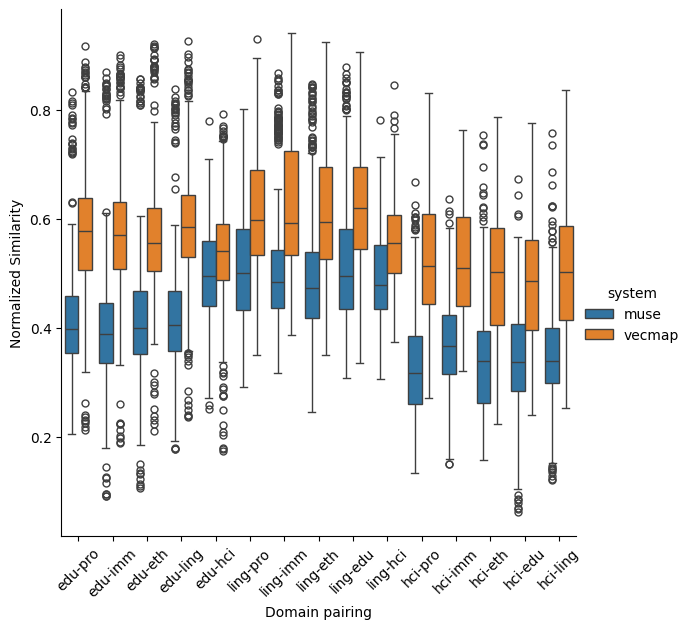

In [ ]:
import seaborn as sns
total_df['community_pairing'] = total_df["src_community"] + "-" + total_df["tgt_community"]
plt.figure(figsize=(12, 8))
catplot = sns.catplot(
    data=total_df,
    x='community_pairing',
    y='normalized_similarity',
    hue='system',
    # col='tgt_community',
    kind='box',
    height=6,
    aspect=1
)

catplot.set_titles('Boxplot of Normalized Similarity by {col_name} Domain')
catplot.set_axis_labels('Domain pairing', 'Normalized Similarity')
for ax in catplot.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
total_df.to_csv('./system_cosine_similarity_results.csv')

plt.figure(figsize=(12, 8))
catplot = sns.catplot(
    data=df,
    x='system',
    y='normalized_similarity',
    hue='src_community',
    col='tgt_community',
    kind='box',
    height=6,
    aspect=1
)

catplot.set_titles('Boxplot of Normalized Similarity by {col_name} Community')
catplot.set_axis_labels('System', 'Normalized Similarity')
plt.show()

# Compute modularity
## These numbers reproduce Table 3 in the manuscript.

In [ ]:
# Copied and slightly modified from https://github.com/akkikiki/modularity_metric
from gensim.models import KeyedVectors
import os
import pickle

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
def build_graph(embedding_file, topk, A_name, indice2word_name, dim):
    # Load the merged embeddings
    word_to_index = {}
    embeddings = []
    with open(embedding_file, 'r') as f:
        next(f)  # Skip the first line (header)
        for idx, line in enumerate(f):
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(list(map(float, parts[1:])))
            word_to_index[word] = idx
            embeddings.append(vector)

    embeddings = np.array(embeddings)

    # Build k-NN graph
    nbrs = NearestNeighbors(n_neighbors=topk + 1, algorithm='auto').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # Create adjacency matrix
    row_indices = []
    col_indices = []
    data = []

    for i in range(indices.shape[0]):
        for j in range(1, topk + 1):  # Skip the first neighbor (itself)
            row_indices.append(i)
            col_indices.append(indices[i, j])
            data.append(1.0)  # Use 1.0 for unweighted graph

    A = csr_matrix((data, (row_indices, col_indices)), shape=(embeddings.shape[0], embeddings.shape[0]))

    # Save the adjacency matrix and index-to-word mapping
    with open(indice2word_name, 'wb') as f:
        pickle.dump(list(word_to_index.keys()), f)

    np.savez(A_name, data=A.data, indices=A.indices, indptr=A.indptr, shape=A.shape)

    print(f"Graph saved as {A_name} and {indice2word_name}")

def calc_weighted_modularity_langs(A_filename, indice2word_filename, langs):
    """
    :param A_filename: Name of the adjacency matrix file
    :param indice2word_filename: Name of the file mapping indices to words
    :param langs: List of prefixes used as tags for each language (e.g., ['hci', 'lin'])
    :return: Normalized modularity score
    """
    A = modularity.load_sparse_csr(A_filename).todok()
    indice2word = pickle.load(open(indice2word_filename, "rb"))

    # Create a mapping from language prefix to community index
    lang_to_indice = {f"{lang}": i for i, lang in enumerate(langs)}
    # print("lang to indiex is ", lang_to_indice)
    num_community = len(langs)
    a_l = [0] * num_community
    e_ll = [0] * num_community
    e_ll_Q_max = [0] * num_community

    degree_list, two_m = modularity.get_degrees(A)

    # Compute a_l values
    for node_id in range(A.shape[0]):
        node_word = indice2word[node_id]
        # print("node word is ", node_word)
        # if len(node_word.split(':')) > 2:
        pairings = node_word.split(':')
        if len (pairings) > 2:
          comm = pairings[0]
          token = ':'
        else:
          comm, token = pairings
        community = lang_to_indice[comm]  # Extract the first 4 characters for the prefix (e.g., 'hci:')

        # community = lang_to_indice[node_word[:4]]  # Extract the first 4 characters for the prefix (e.g., 'hci:')
        k_i = degree_list[node_id]
        a_l[community] += k_i

    # Compute e_ll values
    for processed, e in enumerate(A.items()):
        node1, node2 = e[0]
        node1_word = indice2word[node1]
        node2_word = indice2word[node2]
        # comm1, token_1 = node1_word.split(':')
        # comm2, token_2 = node2_word.split(':')
        pairings = node1_word.split(':')
        if len (pairings) > 2:
          comm1 = pairings[0]
          token1 = ':'
        else:
          comm1, token1 = pairings
        pairings = node2_word.split(':')
        if len (pairings) > 2:
          token2 = ':'
          comm2 = pairings[0]
        else:
          comm2, token2 = pairings
        community_id = lang_to_indice[comm1]  # Ensure prefix extraction matches the prefix format

        e_ll_Q_max[community_id] += 1  # 1 is the maximum possible weight
        if comm1 == comm2:
        # if node1_word[:4] == node2_word[:4]:
            e_ll[community_id] += A[node1, node2]

    # Normalization and modularity calculations
    e_ll = list(map(lambda x: x / two_m, e_ll))
    e_ll_Q_max = list(map(lambda x: x / two_m, e_ll_Q_max))
    a_l = list(map(lambda x: x / two_m, a_l))

    Q = 0
    Q_max = 0
    for i in range(num_community):
        Q += e_ll[i] - (a_l[i] ** 2)
        Q_max += e_ll_Q_max[i] - (a_l[i] ** 2)

    normalized_Q = Q / Q_max
    print(f"Normalized modularity: {normalized_Q:.3f}")
    return normalized_Q

def process_embeddings(embeddings_dict, save_dir, topk=100, dim=100):
    # Iterate through the embeddings dictionary
    for src_domain, target_dict in embeddings_dict.items():
        for tgt_domain, embedding_pair in target_dict.items():
            # Extract src and tgt embeddings
            src_emb = embedding_pair['src_emb']
            tgt_emb = embedding_pair['tgt_emb']

            # Define output names
            merged_file = f"{save_dir}/{src_domain}_{tgt_domain}_merged.txt"
            A_name = f"{save_dir}/{src_domain}_{tgt_domain}_A.npy.npz"
            indice2word_name = f"{save_dir}/{src_domain}_{tgt_domain}_indice2word.pickle"

            # Merge embeddings with prefixes
            merge_embeddings_with_prefix(src_emb, tgt_emb, src_domain, tgt_domain, merged_file)

            # Build the graph
            build_graph(merged_file, topk, A_name, indice2word_name, dim)

            # Calculate modularity
            langs_prefix = [src_domain, tgt_domain]
            print("langs prefix is ", langs_prefix)
            Q_norm = calc_weighted_modularity_langs(A_name, indice2word_name, langs_prefix)
            print(f"Normalized modularity for {src_domain} -> {tgt_domain}: {Q_norm:.3f}\n")


def merge_embeddings_with_prefix(src_vectors, tgt_vectors, src_lang, tgt_lang, output_file):
    # Merge the embeddings and add prefixes
    combined_embeddings = {}
    for word in src_vectors.index_to_key:
        combined_embeddings[f"{src_lang}:{word}"] = src_vectors[word]

    for word in tgt_vectors.index_to_key:
        combined_embeddings[f"{tgt_lang}:{word}"] = tgt_vectors[word]

    # Save merged embeddings in word2vec format
    with open(output_file, 'w') as f:
        f.write(f"{len(combined_embeddings)} {src_vectors.vector_size}\n")
        for word, vector in combined_embeddings.items():
            vector_str = ' '.join(map(str, vector))
            f.write(f"{word} {vector_str}\n")

    print(f"Merged embeddings saved to {output_file}")

### For vecmap, Case Study 2

In [29]:
base_url = "/content/drive/MyDrive/analogy/s2orc/20200705v1/full"

base_url_with_vecmap = base_url + "/level1.abstract.api/vecmap"

community_pairings_original_fastText = {
    'hci-ling': ('participant.v6__hci--ling', 'hci', 'ling'),
    'hci-edu': ('participant.v6__hci--edu', 'hci', 'edu'),
    'ling-hci': ('participant.v6__ling--hci', 'ling', 'hci'),
    'ling-edu': ('participant.v6__ling--edu', 'ling', 'edu'),
    'ling-imm': ('participant.v6__ling--imm', 'ling', 'imm'),
    'edu-hci': ('participant.v6__edu--hci', 'edu', 'hci'),
    'edu-ling': ('participant.v6__edu--ling', 'edu', 'ling'),
    'hci-imm': ('participant.v6__hci--imm', 'hci', 'imm'),
    'hci-eth': ('participant.v6__hci--eth', 'hci', 'eth'),
    'hci-pro': ('participant.v6__hci--pro', 'hci', 'pro'),
    'ling-eth': ('participant.v6__ling--eth', 'ling', 'eth'),
    'ling-pro': ('participant.v6__ling--pro', 'ling', 'pro'),
    'edu-imm': ('participant.v6__edu--imm', 'edu', 'imm'),
    'edu-eth': ('participant.v6__edu--eth', 'edu', 'eth'),
    'edu-pro': ('participant.v6__edu--pro', 'edu', 'pro'),
}
community_names = ['hci', 'ling', 'edu', 'pro', 'eth', 'imm']
comm_lookup_real_vecmap = {}
# for path, (src, tgt) in community_pairings_original_fastText:
for pairing, path_tuple in community_pairings_original_fastText.items():
    path, src, tgt = path_tuple
    print(f"loading {src}-{tgt}...")
    comm_lookup_real_vecmap[src] = embeds.get(src, {})
    comm_lookup_real_vecmap[src][tgt] = {}

    comm_lookup_real_vecmap[src][tgt]["src_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url_with_vecmap, f"{path}/vectors-{src}.txt"), binary=False)
    comm_lookup_real_vecmap[src][tgt]["tgt_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url_with_vecmap, f"{path}/vectors-{tgt}.txt"), binary=False)



loading hci-ling...
loading hci-edu...
loading ling-hci...
loading ling-edu...
loading ling-imm...
loading edu-hci...
loading edu-ling...
loading hci-imm...
loading hci-eth...
loading hci-pro...
loading ling-eth...
loading ling-pro...
loading edu-imm...
loading edu-eth...
loading edu-pro...


In [30]:
save_dir = "pickles_vecmap"
os.makedirs(save_dir, exist_ok=True)

process_embeddings(comm_lookup_real_vecmap, save_dir)

Merged embeddings saved to pickles_vecmap/hci_ling_merged.txt
Graph saved as pickles_vecmap/hci_ling_A.npy.npz and pickles_vecmap/hci_ling_indice2word.pickle
Normalized modularity: 0.289
normalized modularity for hci -> ling: 0.289

Merged embeddings saved to pickles_vecmap/hci_edu_merged.txt
Graph saved as pickles_vecmap/hci_edu_A.npy.npz and pickles_vecmap/hci_edu_indice2word.pickle
Normalized modularity: 0.265
normalized modularity for hci -> edu: 0.265

Merged embeddings saved to pickles_vecmap/hci_imm_merged.txt
Graph saved as pickles_vecmap/hci_imm_A.npy.npz and pickles_vecmap/hci_imm_indice2word.pickle
Normalized modularity: 0.333
normalized modularity for hci -> imm: 0.333

Merged embeddings saved to pickles_vecmap/hci_eth_merged.txt
Graph saved as pickles_vecmap/hci_eth_A.npy.npz and pickles_vecmap/hci_eth_indice2word.pickle
Normalized modularity: 0.297
normalized modularity for hci -> eth: 0.297

Merged embeddings saved to pickles_vecmap/hci_pro_merged.txt
Graph saved as pick

### For MUSE, Case Study 2

In [ ]:
community_pairings = {}
# List of community pairings that I created
community_pairings_original_fastText = [
    ("participant.v2__hci.sg50--ling.sg50/vocab4k/27687fkojo/", "hci", "ling"),
    ("participant.v2__hci.sg50--edu.sg50/vocab4k/4k976ssk9r/", "hci", "edu"),
    ("participant.v2__ling.sg50--hci.sg50/vocab4k/j75he7244v/", "ling", "hci"),
    ("participant.v2__ling.sg50--edu.sg50/vocab7k/m1en7js10h/", "ling", "edu"),
    ("participant.v2__edu.sg50--hci.sg50/vocab4k/rkgir1n6e3/", "edu", "hci"),
    ("participant.v2__edu.sg50--ling.sg50/vocab7k/42bm1rfvui/", "edu", "ling"),
    ("participant.v2__hci.sg50--imm.sg50/vocab4k/nwk1im13f0/", "hci", "imm"),
    ("participant.v2__hci.sg50--eth.sg50/vocab4k/fbwb8x8zya/", "hci", "eth"),
    ("participant.v2__hci.sg50--pro.sg50/vocab4k/kjygz8o6y0/", "hci", "pro"),
    ("participant.v2__ling.sg50--imm.sg50/vocab11k/q824n9jw1e/", "ling", "imm"),
    ("participant.v2__ling.sg50--eth.sg50/vocab9k/3auddcq18i/", "ling", "eth"),
    ("participant.v2__ling.sg50--pro.sg50/vocab7.5k/xp1p3urlrr/", "ling", "pro"),
    ("participant.v2__edu.sg50--imm.sg50/vocab7k/74hao7dzi4/", "edu", "imm"),
    ("participant.v2__edu.sg50--eth.sg50/vocab7k/yr7y44t0qe/", "edu", "eth"),
    ("participant.v2__edu.sg50--pro.sg50/vocab7k/gvum7hbq5b/", "edu", "pro"),
]

comm_lookup_real_muse = {}
base_url ="/content/drive/MyDrive/analogy/s2orc/20200705v1/full/level1.abstract.api/MUSE/"
community_names = ['hci', 'ling', 'edu', 'pro', 'eth', 'imm']
# for pair, (path, src, tgt) in community_pairings_original_fastText.items():
for path, src, tgt in community_pairings_original_fastText:
    print(f"loading {src}-{tgt}...")
    comm_lookup_real_muse[src] = embeds.get(src, {})
    comm_lookup_real_muse[src][tgt] = {}

    comm_lookup_real_muse[src][tgt]["src_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url, f"{path}/vectors-{src}.txt"), binary=False)
    comm_lookup_real_muse[src][tgt]["tgt_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url, f"{path}/vectors-{tgt}.txt"), binary=False)

In [26]:
# Set up parameters
save_dir = "pickles_muse"
os.makedirs(save_dir, exist_ok=True)

# Example of calling the process_embeddings function
process_embeddings(comm_lookup_real_muse, save_dir)

Merged embeddings saved to pickles_muse/hci_ling_merged.txt
Graph saved as pickles_muse/hci_ling_A.npy.npz and pickles_muse/hci_ling_indice2word.pickle
Normalized modularity: 0.231
normalized modularity for hci -> ling: 0.231

Merged embeddings saved to pickles_muse/hci_edu_merged.txt
Graph saved as pickles_muse/hci_edu_A.npy.npz and pickles_muse/hci_edu_indice2word.pickle
Normalized modularity: 0.223
normalized modularity for hci -> edu: 0.223

Merged embeddings saved to pickles_muse/hci_imm_merged.txt
Graph saved as pickles_muse/hci_imm_A.npy.npz and pickles_muse/hci_imm_indice2word.pickle
Normalized modularity: 0.228
normalized modularity for hci -> imm: 0.228

Merged embeddings saved to pickles_muse/hci_eth_merged.txt
Graph saved as pickles_muse/hci_eth_A.npy.npz and pickles_muse/hci_eth_indice2word.pickle
Normalized modularity: 0.228
normalized modularity for hci -> eth: 0.228

Merged embeddings saved to pickles_muse/hci_pro_merged.txt
Graph saved as pickles_muse/hci_pro_A.npy.npz

In [ ]:
%cd /content/drive/MyDrive/analogy/modularity_scripts/

/content/drive/.shortcut-targets-by-id/1DMkmpw7Sy-BHiWNfy2AWABQafU2CJHUT/analogy/modularity_scripts


### For MUSE, Case Study 1

In [52]:
import os
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
community_pairings = {}
# List of community pairings that I created

import os
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

community_pairings_original = [
    ("community1.sg300--community4.sg300_5k/vocab5k/js2u9ntz55", "c1", "c4", "300-5k"),
    ("community1.sg300--community4.sg300/vocab5k/f27qhm93lf", "psy", "mgmt", ""),
    # ("community1.sg50--community4.sg50_5k/vocab5k/8r4xnxvk02", "c1", "c4", "50-5k"),
    # ("community1.sg50--community4.sg50_15k/vocab15k/o12ickhllz", "c1", "c4", "50-15k"),
]
comm_lookup_real_muse = {}
base_url ="/content/drive/MyDrive/analogy/s2orc/20200705v1/full/abstract+body_text/MUSE/"


for path, src, tgt, id in community_pairings_original:
    print(f"loading {src}-{tgt} from base_url...")
    identifier = src+id
    comm_lookup_real_muse[identifier] = comm_lookup_real_muse.get(identifier, {})
    comm_lookup_real_muse[identifier][tgt] = {}

    comm_lookup_real_muse[identifier][tgt]["src_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url, f"{path}/vectors-{src}.txt"), binary=False)
    comm_lookup_real_muse[identifier][tgt]["tgt_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url, f"{path}/vectors-{tgt}.txt"), binary=False)

loading c1-c4 from base_url...
loading psy-mgmt from base_url...


In [ ]:
# Set up parameters
import numpy as np
import modularity
save_dir = "pickles_muse_c1"
os.makedirs(save_dir, exist_ok=True)

# Example of calling the process_embeddings function
process_embeddings(comm_lookup_real_muse, save_dir)

Merged embeddings saved to pickles_muse_c1/c1300-5k_c4_merged.txt
Graph saved as pickles_muse_c1/c1300-5k_c4_A.npy.npz and pickles_muse_c1/c1300-5k_c4_indice2word.pickle
Normalized modularity: 0.280
normalized modularity for c1300-5k -> c4: 0.280

Merged embeddings saved to pickles_muse_c1/psy_mgmt_merged.txt
Graph saved as pickles_muse_c1/psy_mgmt_A.npy.npz and pickles_muse_c1/psy_mgmt_indice2word.pickle


### For VecMAP, Case Study 1

In [54]:
import os
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
community_pairings = {}

community_pairings_original = [
    ("community1.sg300--community4.sg300", "psy", "mgmt", ""),
]
comm_lookup_real_muse = {}
base_url ="/content/drive/MyDrive/analogy/s2orc/20200705v1/full/abstract+body_text/vecmap/"


for path, src, tgt, id in community_pairings_original:
    print(f"loading {src}-{tgt} from base_url...")
    identifier = src+id
    comm_lookup_real_muse[identifier] = comm_lookup_real_muse.get(identifier, {})
    comm_lookup_real_muse[identifier][tgt] = {}

    comm_lookup_real_muse[identifier][tgt]["src_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url, f"{path}/vectors-{src}.txt"), binary=False)
    comm_lookup_real_muse[identifier][tgt]["tgt_emb"] = KeyedVectors.load_word2vec_format(os.path.join(base_url, f"{path}/vectors-{tgt}.txt"), binary=False)

loading psy-mgmt from base_url...


In [55]:
# Set up parameters
save_dir = "pickles_vecmap_c1"
os.makedirs(save_dir, exist_ok=True)

# Example of calling the process_embeddings function
process_embeddings(comm_lookup_real_muse, save_dir)

Merged embeddings saved to pickles_vecmap_c1/psy_mgmt_merged.txt
Graph saved as pickles_vecmap_c1/psy_mgmt_A.npy.npz and pickles_vecmap_c1/psy_mgmt_indice2word.pickle
Normalized modularity: 0.469
normalized modularity for psy -> mgmt: 0.469

